## test rd detection

In [68]:
import os, sys, io, random, subprocess, re
import string
import urllib
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width',200)
import pylab as plt
import seaborn as sns
sns.set_context('poster')
from IPython.display import Image
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

from mtbdiff import utils, analysis

In [26]:
asm = utils.get_mtb_assembly_data()
refs = pd.read_csv('../mtbdiff/data/ref_genomes.csv')
refs

,Organism_Name,Strain,CladeID,BioSample,BioProject,Group,SubGroup,Assembly,Size (Mb),GC%,...,Scaffolds,Genes,Proteins,Release Date,Modify Date,Level,RefSeq FTP,GenBank FTP,species,Assembly_nover
0,Mycobacterium tuberculosis variant bovis BCG s...,BCG Pasteur 1173P2,20829,SAMEA2272684,PRJEA18059,Terrabacteria group,Actinobacteria,GCA_000009445.1,4.37452,65.6,...,1.0,4239.0,4042.0,2007/01/08,2017/05/19,Complete Genome,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,BCG,GCA_000009445
1,Mycobacterium tuberculosis CDC1551,CDC1551,20829,SAMN02603992,PRJNA223,Terrabacteria group,Actinobacteria,GCA_000008585.1,4.40384,65.6,...,1.0,4282.0,4068.0,2001/10/02,2017/05/18,Complete Genome,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,CDC,GCA_000008585
2,Mycobacterium tuberculosis variant africanum,UT307,20829,SAMN04479830,PRJNA311193,Terrabacteria group,Actinobacteria,GCA_001593225.1,4.49350,65.1,...,1.0,4233.0,4009.0,2016/03/16,2017/04/05,Chromosome,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/001...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001...,africanum,GCA_001593225
3,Mycobacterium tuberculosis variant bovis AF212...,AF2122/97,20829,SAMEA20450668,PRJEB15187,Terrabacteria group,Actinobacteria,GCA_000195835.2,4.34990,65.6,...,1.0,4043.0,3988.0,2001/01/25,2018/09/11,Complete Genome,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,bovis,GCA_000195835
4,Mycobacterium tuberculosis variant caprae,Allgaeu,20829,SAMN05257278,PRJNA326075,Terrabacteria group,Actinobacteria,GCA_001941665.1,4.32496,65.6,...,1.0,4197.0,3972.0,2017/01/10,2017/04/16,Chromosome,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/001...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/001...,caprae,GCA_001941665
5,Mycobacterium tuberculosis variant microti,ATCC 19422,20829,SAMN06462280,PRJNA377261,Terrabacteria group,Actinobacteria,GCA_002982215.1,4.24166,65.3,...,258.0,4349.0,4011.0,2018/03/08,2019/03/19,Scaffold,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/002...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/002...,microti,GCA_002982215
6,Mycobacterium tuberculosis F11,F11,20829,SAMN00103286,PRJNA15642,Terrabacteria group,Actinobacteria,GCA_000016925.1,4.42443,65.6,...,1.0,4288.0,4126.0,2007/06/07,2017/05/18,Complete Genome,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/000...,mtb,GCA_000016925
7,Mycobacterium orygis,ASM638503v1,20835,SAMN11890852,PRJNA545406,Terrabacteria group,Actinobacteria,GCA_006385035.1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Scaffold,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/006...,ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCA/006...,orygis,GCA_006385035


## run mtbdiff on ref lineages 

In [101]:
reload(utils)
names = analysis.run_genomes('../test_genomes', outpath='../test_results')
struct, snp =  utils.get_nucdiff_results('../test_results', names)
struct = utils.annotate_results(struct)
S = utils.get_summary(struct)
S[:2]

../test_genomes/GCA_000934325.3.fa GCA_000934325.3
../test_genomes/GCA_001593225.1.fa GCA_001593225.1
../test_genomes/GCA_000009445.1.fa GCA_000009445.1
../test_genomes/GCA_000008585.1.fa GCA_000008585.1
../test_genomes/GCA_001941665.1.fa GCA_001941665.1
../test_genomes/GCA_000016925.1.fa GCA_000016925.1
../test_genomes/GCA_002982215.1.fa GCA_002982215.1
../test_genomes/GCA_006385035.1.fa GCA_006385035.1
247


,start,end,Name,freq,length,RD,gene,region_type
534,2268724,2268725,duplication,8,1,-,"Rv2023A,Rv2024c",other
535,2268724,2268725,insertion,8,1,-,"Rv2023A,Rv2024c",other


In [102]:
struct['assembly'] = struct.label.apply(lambda x: x.split('.')[0],1)
struct = struct.merge(asm, left_on='assembly',right_on='Assembly_nover',how='left')

In [78]:
reload(utils)
rdmat = utils.RD_matrix(struct,columns=['species'])

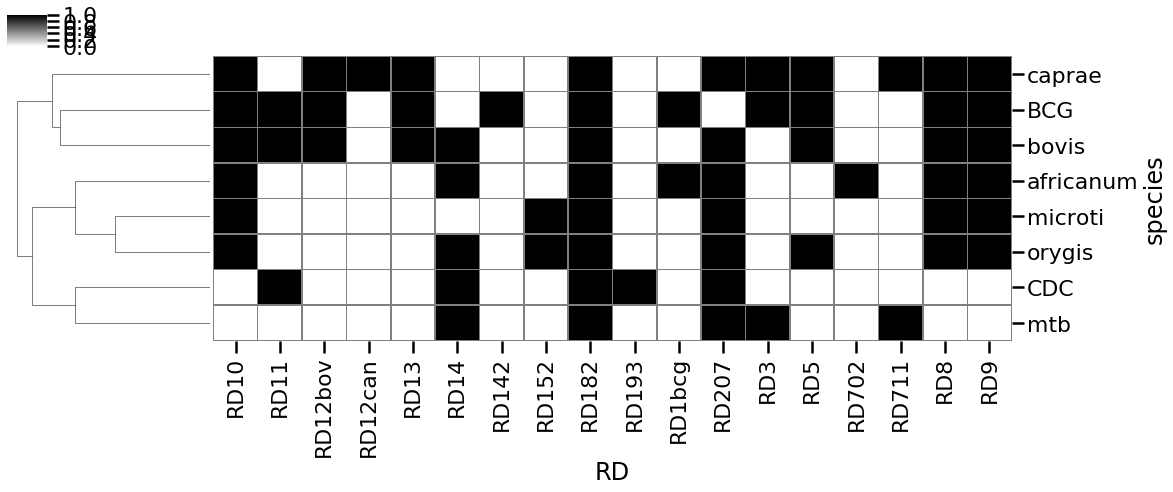

In [87]:
x = rdmat.T.loc[:,rcols].fillna(0)
g = analysis.plot_RD(rdmat.T)
#g=sns.clustermap(rdmat.T,figsize=(18,6),linecolor='gray',cmap='gray_r',lw=0.5, xticklabels=True, col_cluster=False,
#                      yticklabels=True)
g.ax_cbar=None
g.savefig('RD_refs.png')

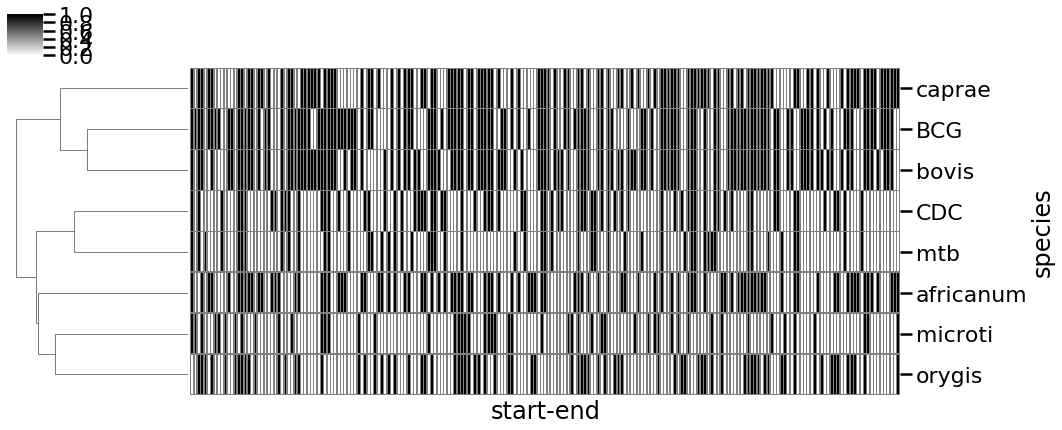

In [119]:
reload(utils)
reload(analysis)
smat = utils.sites_matrix(struct, columns=['species'], freq=1)
analysis.plot_RD(smat.T)

In [18]:
RD = utils.RD
RD[:10]

,RD_name,Start,Stop,Size,Rv
0,RD711,1501713,1503655,1943,Rv1333-1336
1,RD702,216795,218516,1722,Rv0186
2,RD1bcg,4349600,4359000,9400,Rv3871-3879c
3,RD1mic,4340400,4353500,13100,Rv3864-3871
4,RD2seal,2221000,2222900,1901,Rv1978-1979c
5,RD2bcg,2221100,2231800,10701,Rv1978-1988
6,RD12bov,3484700,3487500,2801,Rv3117-3121
7,RD12can,3479400,3491800,12401,Rv3111-3126c
8,RD105,79567,83034,3468,Rv0071-0074
9,RD239,4092077,4092919,843,Rv3651


## fix RD detection

remove false positives

In [47]:
def get_region(x, stcoord='start', endcoord='end'):
    """Get an overlapping RD from coord"""

    if x.Name != 'deletion':
        return '-'
    st = x[stcoord]; end = x[endcoord]
    found = RD[ (st>RD.Start) & (st<RD.Stop) |
                 ((end>RD.Start) & (end<RD.Stop)) |
                 ((st<RD.Start) & (end>RD.Stop))].copy()

    if len(found)>0:
        return found.iloc[0].RD_name
    else:
        return '-'

test = struct[struct.species=='BCG'].copy()
test['RD'] = test.apply(get_region,1)
subcols = ['label','ID','Name','start','end','length','descr','RD']
print (test[test.RD.isin(['RD12bov','RD1mic','RD1bcg'])][subcols])

               label      ID      Name    start      end  length                     descr       RD
716  GCA_000009445.1  SV_138  deletion  3484740  3487514    2774  deletion_3484740:3487514  RD12bov
786  GCA_000009445.1  SV_211  deletion  4350265  4359722    9457  deletion_4350265:4359722   RD1bcg


In [80]:
X = pd.pivot_table(struct,index=['RD'],columns=['species'],values='Name',aggfunc='count')
X

species,BCG,CDC,africanum,bovis,caprae,microti,mtb,orygis
RD,,,,,,,,
-,195.0,124.0,377.0,184.0,198.0,193.0,120.0,282.0
RD10,1.0,NaN,1.0,1.0,1.0,1.0,NaN,1.0
RD11,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN
RD12bov,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
RD12can,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
RD13,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN
RD14,NaN,1.0,1.0,1.0,NaN,NaN,1.0,1.0
RD142,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RD152,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2.0


## use decision matrix based on RD rules to attribute strain 

- simpler than classifer
- just apply the rules and compare to known assemblies

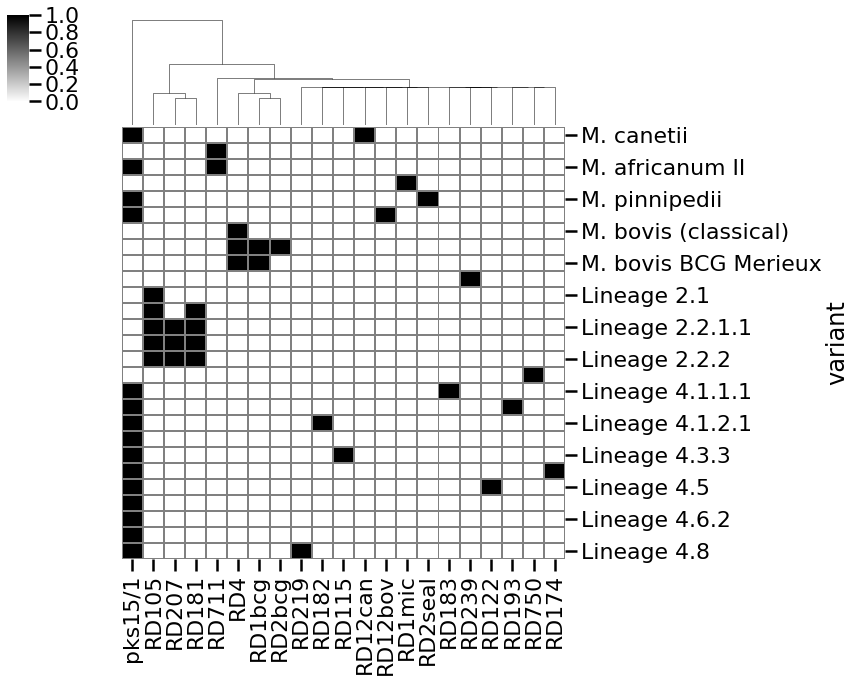

In [95]:
rulesmat = (pd.read_csv('../mtbdiff/data/RD_rules.csv')
            .set_index('variant').drop(columns=['rule','species']))
rcols = rulesmat.columns
#print (rulesmat)
sns.clustermap(rulesmat,cmap='gray_r',row_cluster=0,xticklabels=1,lw=1,linecolor='gray')

In [55]:
test = rdmat.T.loc[:,rcols].fillna(0)
print (test)
def get_id(value):
    for i, r in rulesmat.iterrows():
        print (i,r.values, x)
        if value is r.values:
            print ('ok')
x = test.iloc[0].values
print (x)
get_id(x)

           pks15/1  RD711  RD4  RD1bcg  RD1mic  RD2seal  RD2bcg  RD12bov  RD12can  RD105  ...  RD239  RD750  RD181  RD115  RD122  RD174  RD182  RD183  RD193  RD219
species                                                                                   ...                                                                      
BCG            0.0      0  0.0       1     0.0      0.0     0.0        1        0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0      1    0.0      0    0.0
CDC            0.0      0  0.0       0     0.0      0.0     0.0        0        0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0      1    0.0      1    0.0
africanum      0.0      0  0.0       1     0.0      0.0     0.0        0        0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0      1    0.0      0    0.0
bovis          0.0      0  0.0       0     0.0      0.0     0.0        1        0    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0      1    0.0      0    0.0
caprae         0

In [ ]:
from wordcloud import WordCloud, STOPWORDS
text = '\n'.join(bioproj.Project_Title.astype(str))
wordcloud = WordCloud(
    width = 2500,
    height = 1000,
    background_color = 'gray',
    min_font_size=10,
    max_font_size=220,
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (15,15),
    facecolor = 'w',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.tight_layout(pad=0)
plt.axis("off")